In [1]:
import warnings
warnings.filterwarnings('ignore')

### 패션 MNIST 데이터 불러오기

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1 , 28, 28, 1) / 255.0 # 28x28x1 직육면체가 n개 생김

train_scaled , val_scaled , train_target, val_target = train_test_split(
    train_scaled , train_target , test_size= 0.2, random_state=42
)

- Keras에서 입력데이터가 3차원으로 구성되어 있을 것이라고 가정하고 있으므로 차원을 추가해서 channel차원으로 1을 추가하였음
- train set을 train과 valid로 구분

# 합성곱 신경망 만들기

In [3]:
model = keras.Sequential()

2022-07-21 11:38:04.658367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model.add(
    keras.layers.Conv2D(
        32, # filter 갯수
        kernel_size = 3, # kernel size (3,3,1)
        activation = "relu", 
        padding = "same",
        input_shape = (28,28,1) # 제일 처음 등장하는 layer니까 input_shape 설정 해줌
    )
) # -> (28,28,32)

In [5]:
model.add(
    keras.layers.MaxPooling2D(2) # 2x2 
) # -> (14,14,32)

In [6]:
model.add(
    keras.layers.Conv2D(
        64, # filter의 갯수
        kernel_size = 3,
        activation = "relu",
        padding = "same",
    )
) # -> (14,14,64)

In [7]:
model.add(
    keras.layers.MaxPooling2D(2) # 2x2 
) # -> (7,7,64)

In [10]:
model.add(keras.layers.Flatten()) # 1차원으로 펼쳐줌
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10 , activation = 'softmax'))

입력데이터는 28 * 28 이었는데 최종 딥러닝에 들어가는건 7 * 7 * 64 3136개이다

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

# Model Compile과 훈련

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy', 
    metrics = 'accuracy'
)
checkpoint_cb = keras.callbacks.ModelCheckpoint('../Data/best_cnn_model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(
    train_scaled , 
    train_target ,
    epochs = 20 ,
    validation_data = (val_scaled , val_target) ,
    callbacks = [checkpoint_cb , early_stopping_cb]
)

Epoch 1/20
1500/1500 [==============================] - 30s 19ms/step - loss: 0.5298 - accuracy: 0.8105 - val_loss: 0.3243 - val_accuracy: 0.8770
Epoch 2/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3497 - accuracy: 0.8746 - val_loss: 0.2846 - val_accuracy: 0.8932
Epoch 3/20
1500/1500 [==============================] - 29s 19ms/step - loss: 0.2990 - accuracy: 0.8921 - val_loss: 0.2612 - val_accuracy: 0.9033
Epoch 4/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2691 - accuracy: 0.9025 - val_loss: 0.2445 - val_accuracy: 0.9072
Epoch 5/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2454 - accuracy: 0.9094 - val_loss: 0.2341 - val_accuracy: 0.9136
Epoch 6/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2264 - accuracy: 0.9169 - val_loss: 0.2577 - val_accuracy: 0.9063
Epoch 7/20
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2099 - accuracy: 0.9236 - val_loss: 0.2283 -

> 위 코드는 컴퓨터 퍼포먼스가 좋지않아 빨리 끝내기 위해 처음부터 earlystopping을 사용했지만,        
> 처음 시작할때는 earlystopping을 빼고 해본 다음, 추세를 보고, early stopping옵션을 넣고 다시 돌리는것이 좋다. patience는 보통 5를 쓴다.

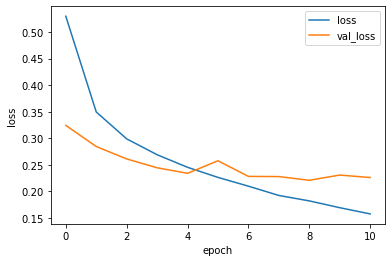

In [13]:
# 시각화 해보기
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [14]:
model.evaluate(val_scaled , val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.2210 - accuracy: 0.9206


[0.22100862860679626, 0.9205833077430725]

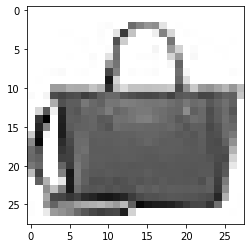

In [15]:
# 이미지로 확인해보기
plt.imshow( val_scaled[0].reshape(28,28) , cmap = "gray_r" )
plt.show()

In [16]:
pred = model.predict(val_scaled[0:1])
print(pred)

1/1 [==============================] - 0s 107ms/step
[[1.4188055e-15 1.9581519e-22 8.7334040e-17 2.2132185e-17 8.6409471e-17
  7.7577258e-18 6.1394748e-15 2.7364026e-17 1.0000000e+00 3.1465949e-14]]


### 계단함수

In [17]:
import numpy as np
classes = ['티셔츠' , '바지','스웨터','드레스','코트','샌들','셔츠','스니커즈','가방','앵클부츠']

In [18]:
print(classes[np.argmax(pred)])

가방


### 시험 데이터로 확인하기

In [19]:
test_scaled = test_input.reshape(-1, 28,28,1) / 255.0

In [20]:
model.evaluate(test_scaled , test_target)

313/313 [==============================] - 2s 5ms/step - loss: 0.2391 - accuracy: 0.9156


[0.23908911645412445, 0.9156000018119812]

---